# Aditep - Capstone Project

## 1. Introduction/Business Problem

In this capstone project, we aim to provide valuable insight on local competitive landscape to those who want to establish new food outlet/eatery in Manhattan. Given the location data of various types of food outlets in Manhattan, we predict the dominant/common type of food outlets present in different parts of Manhattan which will be quite useful while in deciding about the location and type of new food outlet.
Mainly, the businessmen who are interested in setting up a new food outlet/eatery in Manhattan would be interested very interested to have the details of local competitive landscape as a input for their business strategy making. Besides, any already existing eatery owners also would be interested to have the details of this analysis as it would help them understand the geo-distribution of competitors in that locality in order to refine their business strategy.

## 2. Data

In this project, first, we obtain the data that contains the boroughs and the neighborhoods of the New York City. It also contains the latitude and longitude of each neighborhood of every borough in the city. Later, using them, we obtain the data of food outlets/ eateries (along with their type) inside each Borough.


In [1]:
## download all the dependencies that we will need.
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

### Download and Explore Dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


### Load and explore the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Tranform the data into a pandas dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [11]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [12]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [13]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = 'DOTZGUIROBQMD1ZMEHHP0XRCQSVE2JPWB2T2YGQH01X1HQGW' # your Foursquare ID
CLIENT_SECRET = 'UL24ZMFEB1XZJJFK3IYC1UZR1Z5VGR3JLP3BPTNIJMM0EAW3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DOTZGUIROBQMD1ZMEHHP0XRCQSVE2JPWB2T2YGQH01X1HQGW
CLIENT_SECRET:UL24ZMFEB1XZJJFK3IYC1UZR1Z5VGR3JLP3BPTNIJMM0EAW3


In [50]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        CategoryId,
        LIMIT)
        url 
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
LIMIT  = 1000
radius = 15000
CategoryId= '4d4b7105d754a06374d81259'

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

In [78]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
2,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
3,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
4,Marble Hill,40.876551,-73.91066,Parrilla Latina,40.877473,-73.906073,Steakhouse


In [56]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 121 uniques categories.


# 3. Methodology

In [57]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

In [58]:
manhattan_onehot.shape

(2634, 122)

In [59]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Battery Park City,0.0,0.000000,0.040000,0.000000,0.000000,0.000000,0.00,0.00,0.040000,0.000000,0.000000,0.0,0.04,0.0,0.000000,0.0,0.080000,0.0,0.000000,0.040000,0.0,0.0,0.00,0.000000,0.0,0.0,0.080000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.040000,0.00,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.08,0.0,0.080000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.040000,0.040000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.160000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.040000,0.120000,0.0,0.040000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.04,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Carnegie Hill,0.0,0.000000,0.014706,0.000000,0.014706,0.000000,0.00,0.00,0.000000,0.014706,0.088235,0.0,0.00,0.0,0.014706,0.0,0.000000,0.0,0.000000,0.102941,0.0,0.0,0.00,0.000000,0.0,0.0,0.014706,0.0,0.0,0.0,0.014706,0.00,0.029412,0.000000,0.00,0.0,0.00,0.00,0.000000,0.0,0.029412,0.0,0.0,0.00,0.0,0.014706,0.044118,0.000000,0.0,0.0,0.0,0.014706,0.0,0.014706,0.00,0.029412,0.0,0.000000,0.088235,0.0,0.044118,0.0,0.0,0.0,0.014706,0.0,0.0,0.0,0.00,0.014706,0.029412,0.000000,0.0,0.0,0.0,0.029412,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.014706,0.029412,0.0,0.014706,0.000000,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.073529,0.0,0.0,0.029412,0.00,0.000000,0.0,0.014706,0.0,0.0,0.0,0.0,0.0,0.000000,0.029412,0.0
2,Central Harlem,0.0,0.065217,0.043478,0.000000,0.000000,0.000000,0.00,0.00,0.021739,0.021739,0.021739,0.0,0.00,0.0,0.021739,0.0,0.021739,0.0,0.021739,0.021739,0.0,0.0,0.00,0.065217,0.0,0.0,0.086957,0.0,0.0,0.0,0.086957,0.00,0.000000,0.021739,0.00,0.0,0.00,0.00,0.021739,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.043478,0.086957,0.0,0.0,0.

In [60]:
manhattan_grouped.shape

(40, 122)

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Pizza Place,Sandwich Place,Burger Joint,Food Court,Chinese Restaurant,Food Truck,Steakhouse,Donut Shop,American Restaurant,Café
1,Carnegie Hill,Pizza Place,Café,Italian Restaurant,Bakery,Sushi Restaurant,Japanese Restaurant,French Restaurant,Restaurant,Diner,New American Restaurant
2,Central Harlem,Fried Chicken Joint,Deli / Bodega,Southern / Soul Food Restaurant,Chinese Restaurant,Caribbean Restaurant,African Restaurant,Seafood Restaurant,French Restaurant,Sandwich Place,Pizza Place
3,Chelsea,Café,French Restaurant,Bakery,American Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Seafood Restaurant,Pizza Place
4,Chinatown,Chinese Restaurant,Bakery,Dumpling Restaurant,Vietnamese Restaurant,Malay Restaurant,Dim Sum Restaurant,Noodle House,Mexican Restaurant,Hotpot Restaurant,Pizza Place


In [63]:
neighborhoods_venues_sorted.shape

(40, 11)

### Cluster Neighborhoods

In [65]:
# set number of clusters
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
import matplotlib.pyplot as plt2
Kmax =7
def calculate_WSS(points, kmax):
  sse = []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    sse.append(kmeans.inertia_)
  return sse
sse_data = calculate_WSS(manhattan_grouped_clustering, Kmax)
plt2.plot(range(2,Kmax+1),sse_data)
plt2.title('Finding out optimum value of K', fontsize=18)
plt2.ylabel('Sum of Squared Error', fontsize=18)
plt2.xlabel('K', fontsize=18)
plt2.xticks(fontsize=18)

(array([1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 8 Text xticklabel objects>)

In [66]:
kclusters = 4
kmeans = KMeans(n_clusters = kclusters).fit(manhattan_grouped_clustering)
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Sandwich Place,American Restaurant,Deli / Bodega,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Diner,Donut Shop,Asian Restaurant,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bakery,Dumpling Restaurant,Vietnamese Restaurant,Malay Restaurant,Dim Sum Restaurant,Noodle House,Mexican Restaurant,Hotpot Restaurant,Pizza Place
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Deli / Bodega,Pizza Place,Chinese Restaurant,Mexican Restaurant,Bakery,Spanish Restaurant,Latin American Restaurant,Donut Shop,Restaurant,Sandwich Place
3,Manhattan,Inwood,40.867684,-73.921210,0,Pizza Place,Restaurant,Mexican Restaurant,Café,Bakery,American Restaurant,Spanish Restaurant,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Deli / Bodega,Pizza Place,Mexican Restaurant,Café,Sandwich Place,Chinese Restaurant,Donut Shop,Indian Restaurant,Sushi Restaurant,Bakery


## 4. Results

In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    #cluster = int(cluster1)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



## 5. Discussion
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.


### Cluster 1

Hello


Text(0.5, 0, 'Type of food outlet')

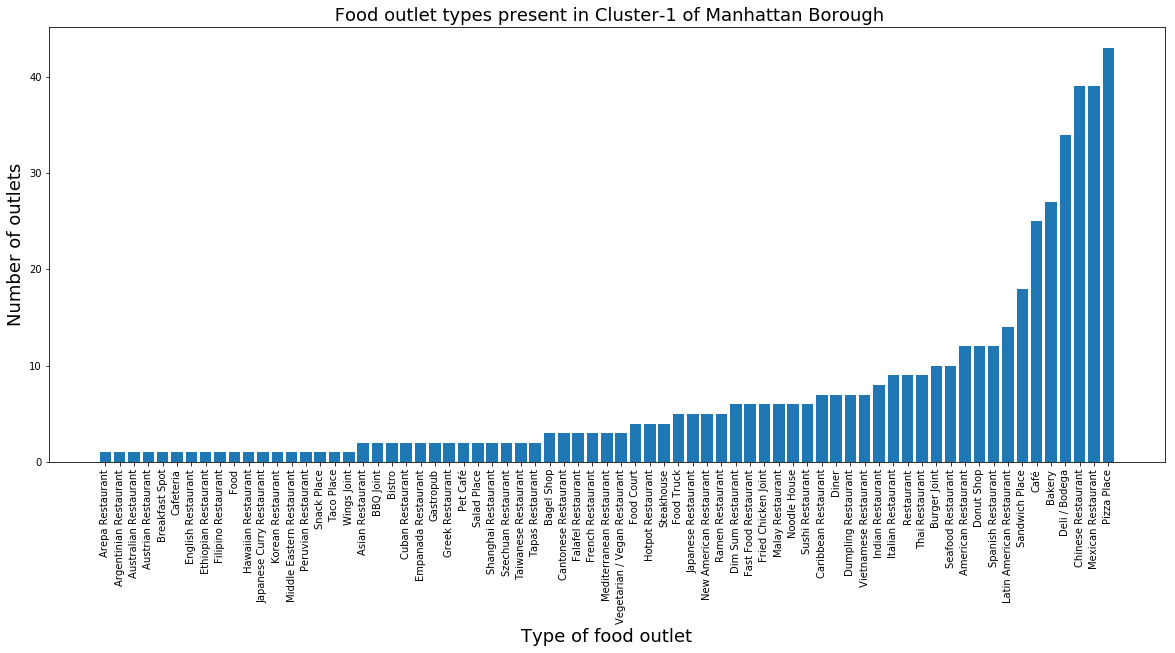

In [70]:
df_test = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = manhattan_onehot.loc[manhattan_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-1 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)

We can observe that Bakery, Deli / Bodega, Chinese Restaurant, Mexican Restaurant, Pizza Place are the top 5 common/dominant types of food outlets present in Cluster-1 of Manhattan. This suggests that any new food outlet to be launched in Cluster-1 make sure that type of food offered is different to those 5 types of food outlets in order to draw more customers. It also suggests that Cluster-1 of Manhattan is not the ideal place to open a new Bakery, Deli / Bodega, Chinese Restaurant, Mexican Restaurant, Pizza Place.


Findout the Neighborhoods present inside Cluster-1

In [71]:
df_test['Neighborhood']

1              Chinatown
2     Washington Heights
3                 Inwood
4       Hamilton Heights
5         Manhattanville
7            East Harlem
20       Lower East Side
25      Manhattan Valley
28     Battery Park City
Name: Neighborhood, dtype: object

### Cluster 2

Hello


Text(0.5, 0, 'Type of food outlet')

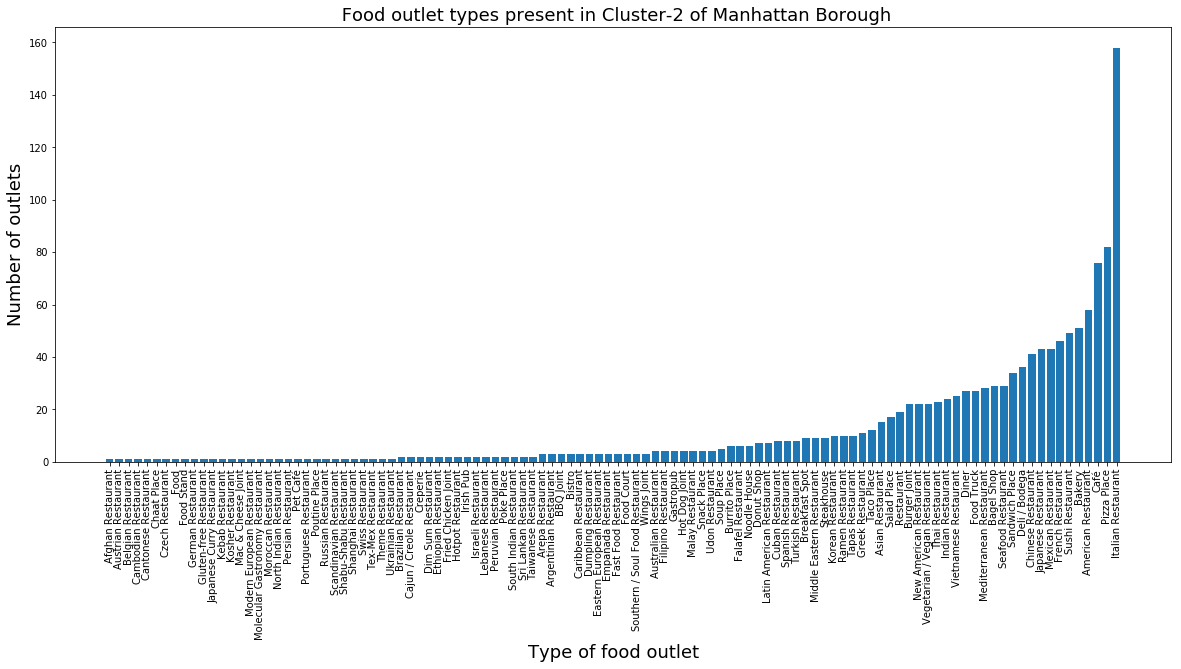

In [72]:
df_test = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = manhattan_onehot.loc[manhattan_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-2 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)


In [73]:
df_test['Neighborhood']

8       Upper East Side
9             Yorkville
10           Lenox Hill
12      Upper West Side
13       Lincoln Square
17              Chelsea
18    Greenwich Village
19         East Village
22         Little Italy
23                 Soho
24         West Village
27             Gramercy
30        Carnegie Hill
31                 Noho
32         Civic Center
34         Sutton Place
38             Flatiron
Name: Neighborhood, dtype: object

### Cluster 3

Hello


Text(0.5, 0, 'Type of food outlet')

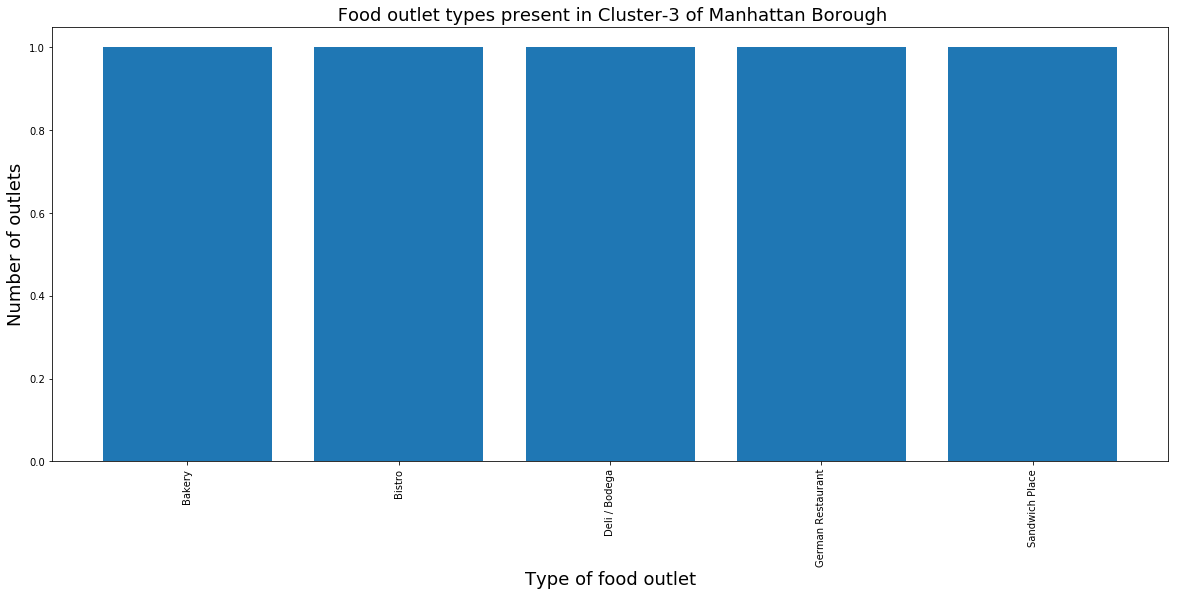

In [74]:
df_test = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = manhattan_onehot.loc[manhattan_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-3 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)

In [75]:
df_test['Neighborhood']

37    Stuyvesant Town
Name: Neighborhood, dtype: object

### Cluster 4

Hello


Text(0.5, 0, 'Type of food outlet')

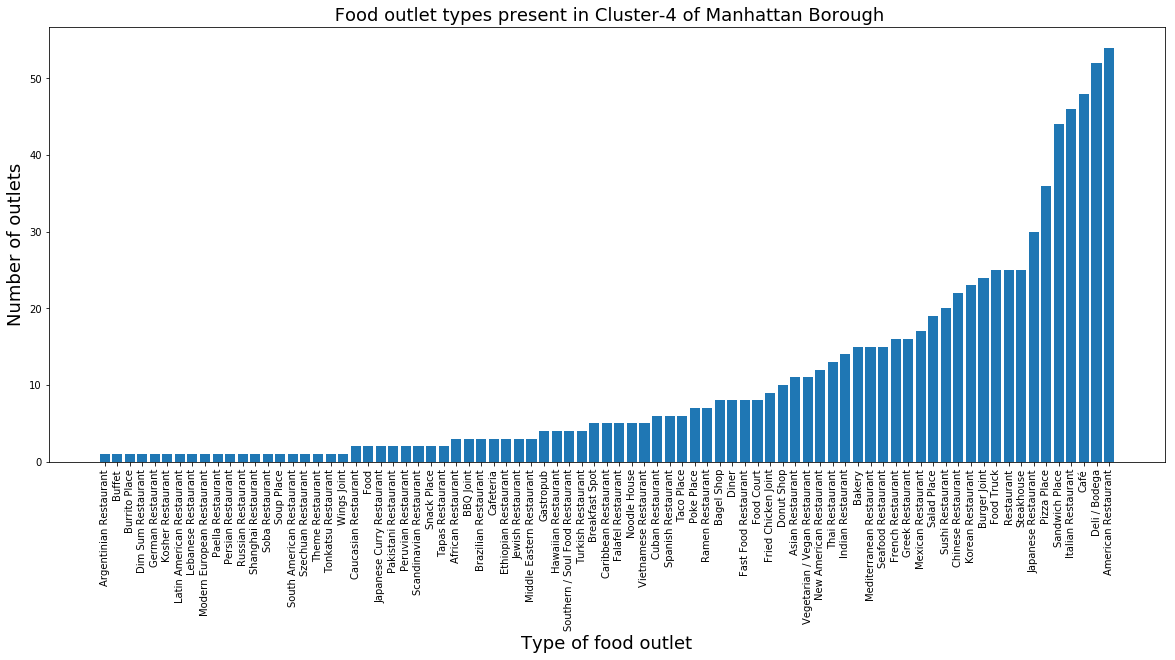

In [76]:
df_test = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = manhattan_onehot.loc[manhattan_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-4 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)

In [77]:
df_test['Neighborhood']

0             Marble Hill
6          Central Harlem
11       Roosevelt Island
14                Clinton
15                Midtown
16            Murray Hill
21                Tribeca
26    Morningside Heights
29     Financial District
33          Midtown South
35             Turtle Bay
36             Tudor City
39           Hudson Yards
Name: Neighborhood, dtype: object

## 6. Conclusion

In this project, we predicted the dominant/common type of food outlets present in different parts of New York city with help of location data of various types of food outlets in New York city. Using the latitudes and longitudes of neighborhoods in NY city, we obtained the location data of different types of food outlets with the help of Foursquare API.
Neighborhoods of each borough in NY city has been partitioned into different clusters using K-means clustering algorithm by taking top 10 common food outlets of each neighborhood as a data sample. This analysis can be helpful for those businessmen who are planning to open a new food outlet in NY city. It can help them in deciding the type of food outlet that provides them the competitive advantage